In [1]:
%cd ../

/home/zephyrus/Projects/mercury-duckling


In [111]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel_v, sobel_h, threshold_local
from skimage.filters.rank import entropy
from skimage.morphology import ball, disk
from omegaconf import OmegaConf

import torch
from torchvision import tv_tensors
from torchvision.datasets import CocoDetection
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.datasets import wrap_dataset_for_transforms_v2
from mercury_duckling.datasets.transforms import (
    Blobify,
    OneHotEncodeFromBlobs,
    ResizeLongestSideAndPad,
    Colormap,
    Clahe, 
    MinMaxNormalization,
)
from mercury_duckling.models import build_predictor
from mercury_duckling.datasets import ThermalDataset
from mercury_duckling.utils import show_box, show_points, plot_image_and_mask, show_mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
transform = None
target_transform = None
transforms = v2.Compose(
    [
        v2.ToImage(),
        ResizeLongestSideAndPad(target_size=(256, 320)),
        Blobify(),
        OneHotEncodeFromBlobs(),
        v2.ToDtype({tv_tensors.Image: torch.float32, "others": None}, scale=False),
    ]
)
root="../data/merged_dataset_delam_thm"
dataset = ThermalDataset(
    root=root,
    annFile=os.path.join(root, "annotations/delamination.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset = wrap_dataset_for_transforms_v2(
    dataset,
    target_keys=["masks", "labels", "boxes", "image_id"]
)
root="../data/merged_dataset_concrete"
dataset_concrete = CocoDetection(
    root=root,
    annFile=os.path.join(root, "annotations/concrete.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset_concrete = wrap_dataset_for_transforms_v2(
    dataset_concrete,
    target_keys=["masks", "labels", "boxes", "image_id"]
)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [332]:
idx = 250
input, target = dataset[idx]
print("Image ID:", target["image_id"])
print(
    "input shape:", input.shape, 
    "\ninput class:", type(input),
    "\ninput dtype:", input.dtype
)
print(
    "\ntarget shape:", target["masks"].shape,
    "\nnumber of targets:", len(target["boxes"]),
    "\ntarget class:", type(target["masks"]),
    "\ntarget dtype:", target["masks"].dtype
)

Image ID: 251
input shape: torch.Size([1, 256, 320]) 
input class: <class 'torchvision.tv_tensors._image.Image'> 
input dtype: torch.float32

target shape: torch.Size([2, 256, 320]) 
number of targets: 2 
target class: <class 'torchvision.tv_tensors._mask.Mask'> 
target dtype: torch.uint8


In [333]:
def get_visible(file_name, vis_dataset):
    vis_name = file_name.replace("IR", "VIS")
    for _, img_info in vis_dataset.coco.imgs.items():
        if img_info["file_name"] == vis_name:
            return img_info["id"]

file_name = dataset.coco.imgs[idx + 1]["file_name"]
print(file_name)
vis_input, vis_target = dataset_concrete[get_visible(file_name, dataset_concrete) - 1]

IR04_86.jpg


In [334]:
normalization = MinMaxNormalization()
clahe_transform = Clahe()
cmap_transform = Colormap(colormap="gray")

input *= torch.tensor(vis_target["masks"].sum(dim=0).bool())
input = tv_tensors.Image(input)

input_clahe = normalization(input)
input_clahe = clahe_transform(input_clahe)
input_clahe = cmap_transform(input_clahe)

input_cmap  = cmap_transform(input)

/tmp/ipykernel_1440854/1158589730.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input *= torch.tensor(vis_target["masks"].sum(dim=0).bool())


In [335]:
pil_input_cmap = to_pil_image(input_cmap)
entropy_img = entropy(
    np.array(pil_input_cmap.convert("L"),dtype=np.uint8),
    disk(16),
    mask= vis_target["masks"].sum(dim=0).bool().numpy()
)

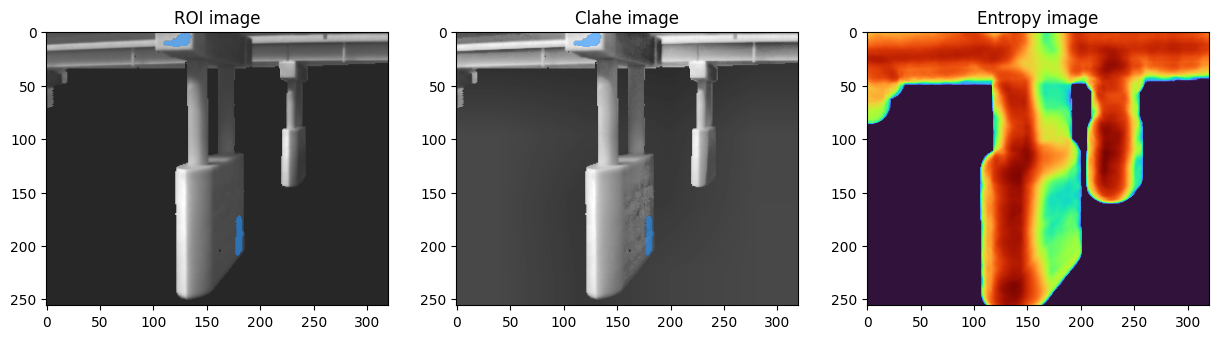

In [336]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

img0 = ax0.imshow(pil_input_cmap, cmap=None)
ax0.set_title("ROI image")
ax1.imshow(to_pil_image(input_clahe), cmap=None)
ax1.set_title("Clahe image")
ax2.imshow(entropy_img / entropy_img.max(), cmap='turbo')
ax2.set_title("Entropy image")
for ax in (ax0, ax1):
    for mask in target["masks"]:
        show_mask(mask.numpy(),ax, random_color=False)

In [346]:
prompts = [{
    "type": "point",
    "coords": [125, 5],
    "label": True,
}]

In [338]:
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

input_clahe_rgb = input_clahe.permute(1, 2, 0).numpy()
segments_fz = felzenszwalb(input_clahe_rgb, scale=200, sigma=0.5, min_size=100)
segments_slic = slic(
    input_clahe_rgb,
    n_segments=150,
    compactness=10,
    sigma=1,
    start_label=1
)
segments_quick = quickshift(input_clahe_rgb, kernel_size=3, max_dist=12, ratio=0.5)
gradient = sobel(input_clahe_rgb[..., :1])
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

Felzenszwalb number of segments: 128
SLIC number of segments: 135
Quickshift number of segments: 108
Watershed number of segments: 252


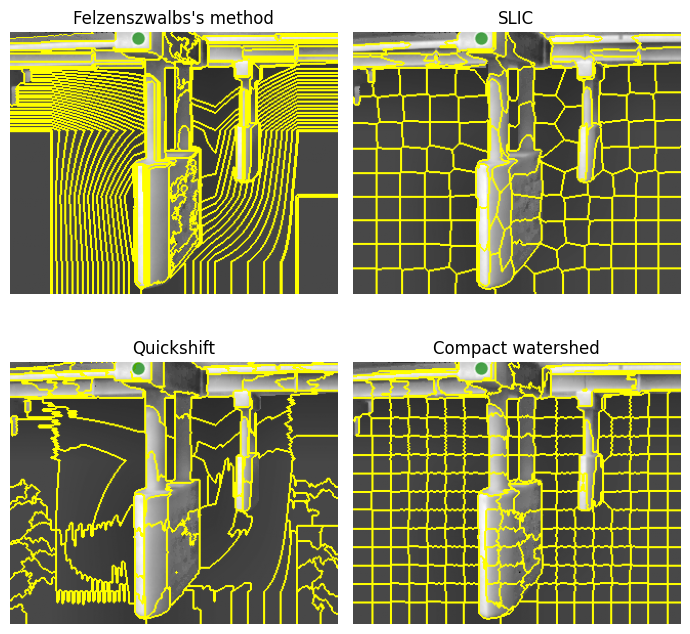

In [347]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(input_clahe_rgb, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(input_clahe_rgb, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(input_clahe_rgb, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(input_clahe_rgb, segments_watershed[..., 0]))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    show_points(
        np.array([p["coords"] for p in prompts]),
        np.array([l["label"] for l in prompts]),
        a, marker_size=100
    )
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [348]:
pre_sp = segments_slic[prompts[0]["coords"][1], prompts[0]["coords"][1]]
pre_mask = torch.zeros_like(input)
pre_mask[:, np.where(segments_slic == pre_sp)] = 5.
pre_mask = v2.functional.resize(
    pre_mask,
    (256, 256),
    interpolation=v2.functional.InterpolationMode.NEAREST
)

In [349]:
config = OmegaConf.load("mercury_duckling/configs/model.yaml")
config.selected_model = "SAM"
sam = build_predictor(config)
sam._setup_model(device='cuda:0')

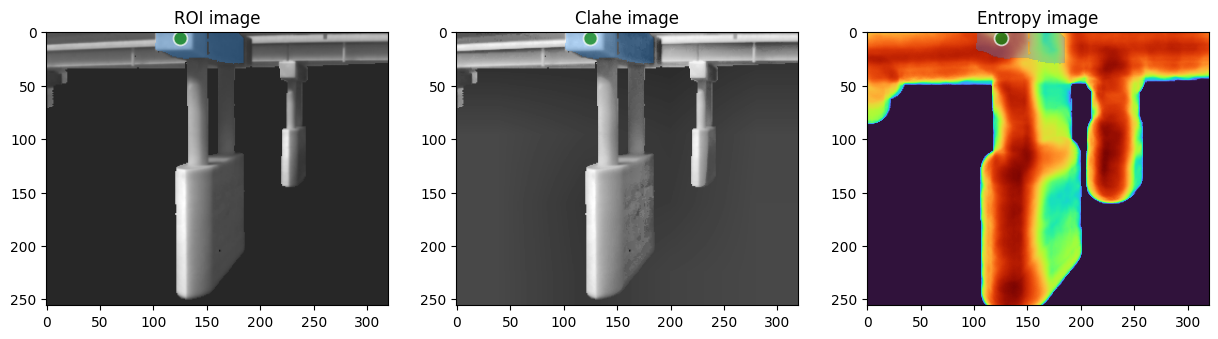

In [350]:
mask, aux = sam.predict(input_clahe.permute(1, 2, 0).numpy(), prompts, None, id=idx)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
img0 = ax0.imshow(pil_input_cmap, cmap=None)
ax0.set_title("ROI image")
ax1.imshow(to_pil_image(input_clahe), cmap=None)
ax1.set_title("Clahe image")
ax2.imshow(entropy_img / entropy_img.max(), cmap='turbo')
ax2.set_title("Entropy image")

for ax in (ax0, ax1, ax2):
    show_mask(mask.numpy(),ax, random_color=False, alpha=0.3)
    show_points(
        np.array([p["coords"] for p in prompts]),
        np.array([l["label"] for l in prompts]),
        ax, marker_size=100
    )

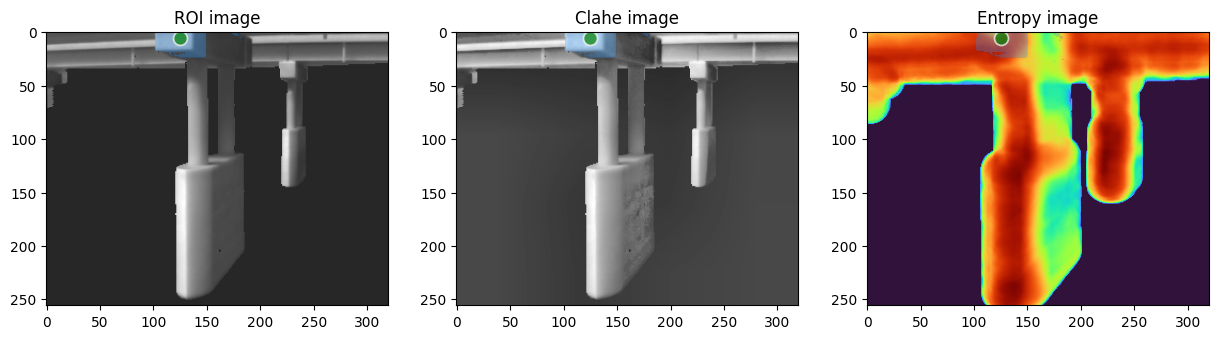

In [351]:
mask, aux = sam.predict(input_cmap.permute(1, 2, 0).numpy(), prompts, pre_mask, id=idx)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
img0 = ax0.imshow(pil_input_cmap, cmap=None)
ax0.set_title("ROI image")
ax1.imshow(to_pil_image(input_clahe), cmap=None)
ax1.set_title("Clahe image")
ax2.imshow(entropy_img / entropy_img.max(), cmap='turbo')
ax2.set_title("Entropy image")

for ax in (ax0, ax1, ax2):
    show_mask(mask.numpy(),ax, random_color=False, alpha=0.3)
    show_points(
        np.array([p["coords"] for p in prompts]),
        np.array([l["label"] for l in prompts]),
        ax, marker_size=100
    )

In [30]:
roi_coords = np.where(mask.numpy() == 1)
x_min = int(np.min(roi_coords[1]))
x_max = int(np.max(roi_coords[1]))
y_min = int(np.min(roi_coords[0]))
y_max = int(np.max(roi_coords[0]))

roi_bbox = tv_tensors.BoundingBoxes(
    [x_min, x_max, y_min, y_max],
    format=tv_tensors.BoundingBoxFormat.XYXY,
    canvas_size=mask.shape
)